In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [47]:
# Load in data for regression analysis
mlr_example = pd.read_csv('Automobile_data.csv')

# Identify target variable and potential predictors
print(mlr_example.columns)

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')


In [48]:
# Isolate predictor variables into new dataframe
model_data = mlr_example[['engine-size', 'horsepower', 'fuel-type', 'price', 'highway-mpg']].copy()
model_data.columns = ['engine_size', 'horsepower', 'fuel_type', 'price', 'highway_mpg']

model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   engine_size  205 non-null    int64 
 1   horsepower   205 non-null    object
 2   fuel_type    205 non-null    object
 3   price        205 non-null    object
 4   highway_mpg  205 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 8.1+ KB


In [49]:
# Check values to make sure you can perform regression
print(model_data['horsepower'].unique())

['111' '154' '102' '115' '110' '140' '160' '101' '121' '182' '48' '70'
 '68' '88' '145' '58' '76' '60' '86' '100' '78' '90' '176' '262' '135'
 '84' '64' '120' '72' '123' '155' '184' '175' '116' '69' '55' '97' '152'
 '200' '95' '142' '143' '207' '288' '?' '73' '82' '94' '62' '56' '112'
 '92' '161' '156' '52' '85' '114' '162' '134' '106']


We can see that the horsepower column isn't entered as numeric values even though it appeared to be appropriate based on the table summary. Horsepower, and a few of the other columns also have a sentinel value of '?' to indicate missing values.

So, we need to update/replace missing values and make sure the values are stored as numeric.

This same check/update should be done to all of the other columns.

In [50]:
# Replace the sentinel values in columns with null values
cols = model_data.columns
for col in cols:
	model_data[col].replace('?', np.nan, inplace=True)

# update dtypes for columns for regression
model_data['fuel_type'] = model_data['fuel_type'].astype('category')
model_data['price'] = pd.to_numeric(model_data['price'])
model_data['horsepower'] = pd.to_numeric(model_data['horsepower'])

# drop null values
model_data = model_data.dropna()

In [52]:
# Create regression model using smf.ols
model = smf.ols('price ~ engine_size + horsepower + highway_mpg + fuel_type', data=model_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     209.7
Date:                Sat, 30 Sep 2023   Prob (F-statistic):           2.84e-69
Time:                        15:26:07   Log-Likelihood:                -1903.4
No. Observations:                 199   AIC:                             3817.
Df Residuals:                     194   BIC:                             3833.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3071.2513   3175.980      0.967      0.335   -3192.632    9335.134
fuel_type[T.gas] -3882.1745    910.199     -4.265      0.000   -5677.331   -2087.018
engine_size        102.6287     11.343      9.048      0.000      80.258     124.999
horsepower          58.0126     14.923      3.888      0.000      28.581      87.444
highway_mpg       -174.3590     61.706     -2.826      0.005    -296.059     -52.659
==============================================================================
Omnibus:                       11.078   Durbin-Watson:                   0.841
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.221
Skew:                           0.243   Prob(JB):                     4.07e-05
Kurtosis:                       4.484   Cond. No.                     2.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
# Sequential F Test on regression model

sequential_aov_table = sm.stats.anova_lm(model, typ=1)
sequential_aov_table

,df,sum_sq,mean_sq,F,PR(>F)
fuel_type,1.0,1.496960e+08,1.496960e+08,12.267655,5.720085e-04
engine_size,1.0,9.503851e+09,9.503851e+09,778.844709,7.616789e-70
horsepower,1.0,4.863750e+08,4.863750e+08,39.858640,1.818820e-09
highway_mpg,1.0,9.742880e+07,9.742880e+07,7.984332,5.212118e-03
Residual,194.0,2.367285e+09,1.220250e+07,NaN,NaN


The Sequential F test adds in the predictors in a set order, and tests the significance of a predictor against all of the other predictors already added to the reduced model.
For example, in our case, consider the test here on *horsepower*. We are using the following models to conduct our F test on the significance of *horsepower* in predicting price:

Reduced Model: *__price ~ fuel_type + engine_size__*

Full Model: *__price ~ fuel_type + engine_size + horsepower__*

For this test, highway_mpg isn't part of either model. This brings us to the Partial F Test.

In [43]:
# Partial F Test on regression model

partial_aov_table = sm.stats.anova_lm(model, typ=2)
partial_aov_table

,sum_sq,df,F,PR(>F)
fuel_type,2.219861e+08,1.0,18.191857,3.118291e-05
engine_size,9.989917e+08,1.0,81.867806,1.530876e-16
horsepower,1.844180e+08,1.0,15.113133,1.389653e-04
highway_mpg,9.742880e+07,1.0,7.984332,5.212118e-03
Residual,2.367285e+09,194.0,NaN,NaN


The Partial F Test differs from the Sequential F Test in that the test for each predictor is done using ALL other predictors in the model as well. We can see that this changes the F-statistic for all of the predictor variables in the ANOVA table above compared to the Sequential F Test table, except for *highway_mpg*, because in the sequential test, it was already tested with all of the other variables included in the model.

So, let's consider the test on significance for *horsepower* again, this time using the Partial F Test. WE would have the following models for our test:

Reduced Model: *__price ~ fuel_type + engine_size + highway_mpg__*

Full Model: *__price ~ fuel_type + engine_size + highway_mpg + horsepower__*

The Partial F Test will give the same results as the t tests for each predictor in the original regression, as the t tests also look to test the significant of each individual predictor variable given all of the other predictors included in the model.

In [58]:
# additional imports needed to check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Calculate the VIF for each predictor variable included in model
vif_y, vif_x = dmatrices('price ~ engine_size + horsepower + highway_mpg + fuel_type',
						 data=model_data, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(vif_x.values, i) for i in range(vif_x.shape[1])]
vif['Features'] = vif_x.columns
print(vif)

   VIF Factor          Features
0  164.497754         Intercept
1    1.221390  fuel_type[T.gas]
2    3.639274       engine_size
3    5.095827        horsepower
4    2.898497       highway_mpg


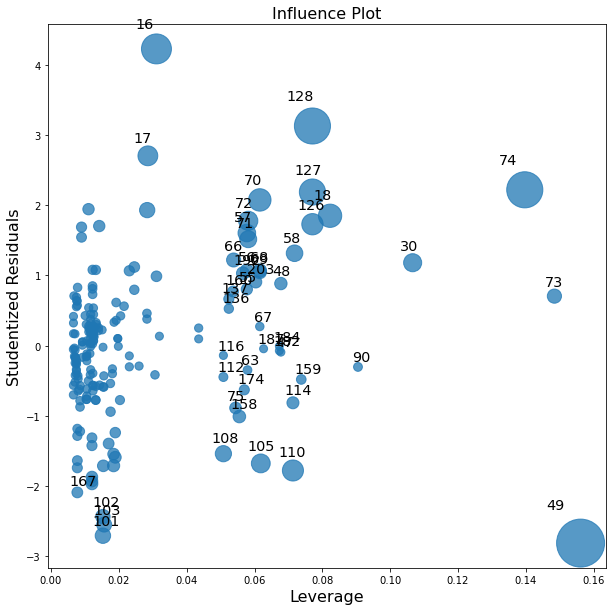

In [61]:
# check for influential points in the model
# graph is an easy way to visualize influential points
fig, ax = plt.subplots(figsize=(10,10))
fig = sm.graphics.influence_plot(model, ax=ax, criterion='cooks')